In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Reader, Dataset

In [2]:
ratings=pd.read_csv("./ml-latest-small/ratings.csv")
ratings.sort_values(by=['userId', 'movieId'], inplace=True)

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
ratings.shape

(100836, 4)

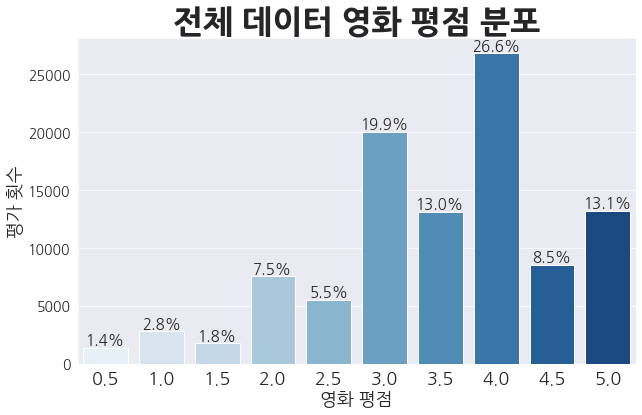

In [19]:
sns.set_style("darkgrid")
fig = plt.figure()
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 15
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.figsize'] = (10, 6)

ax = sns.countplot(x="rating", data=ratings, palette="Blues")
ax.set_xlabel("영화 평점")
ax.set_ylabel("평가 횟수")
ax.set_title("전체 데이터 영화 평점 분포", fontsize=32, fontweight='bold')
ncount = len(ratings)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom')
plt.savefig('전체 데이터 영화 평점 분포.png')
plt.show()

In [5]:
# 영화 한 편당 평점 개수. groupby 함수로 카운팅한다.
data = ratings.groupby('movieId')['rating'].count().reset_index().sort_values('rating', ascending=False)

In [6]:
# 평점 개수별 영화 개수 
data.groupby('rating').count().reset_index()[:20]

,rating,movieId
0,1,3446
1,2,1298
2,3,800
3,4,530
4,5,382
5,6,319
6,7,278
7,8,230
8,9,172
9,10,148


In [7]:
data.movieId.nunique()

9724

In [8]:
data[:5]

,movieId,rating
314,356,329
277,318,317
257,296,307
510,593,279
1938,2571,278


In [9]:
data = ratings.groupby('movieId')['rating'].count().reset_index().clip(upper=30)

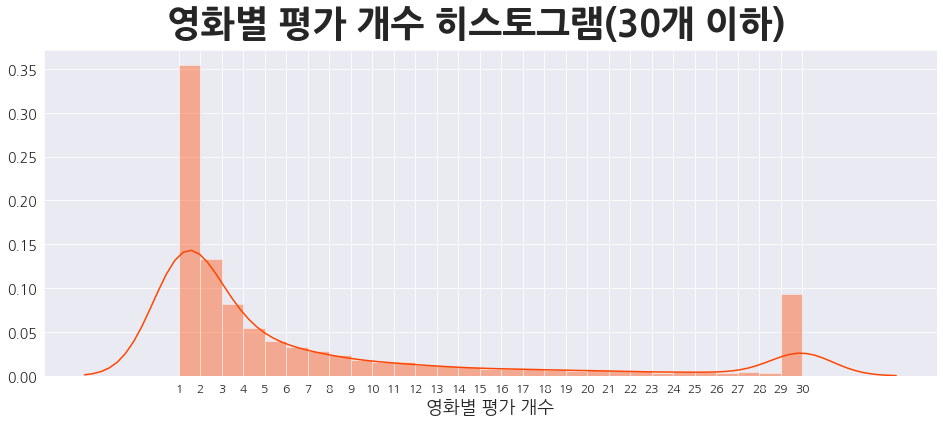

In [10]:
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.figsize'] = (16, 6)
sns.distplot(data['rating'], list(range(1,31)), color='orangered')
plt.xlabel('영화별 평가 개수')
plt.suptitle('영화별 평가 개수 히스토그램(30개 이하)', fontsize=36, fontweight='bold')
plt.xticks(list(range(1,31)))
plt.savefig('영화별 평가 개수 히스토그램.png')
plt.show()

In [11]:
# 유저별 평가 영화 개수
ratings.groupby('userId')['rating'].count().reset_index().sort_values('rating',ascending=False)

,userId,rating
413,414,2698
598,599,2478
473,474,2108
447,448,1864
273,274,1346
...,...,...
441,442,20
568,569,20
319,320,20
575,576,20


In [12]:
min_movie_ratings = 5
filter_movies = ratings['movieId'].value_counts() >= min_movie_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

ratings_new = ratings[ratings['movieId'].isin(filter_movies)]
print('The original data frame shape:\t{}'.format(ratings.shape))
print('The new data frame shape:\t{}'.format(ratings_new.shape))

The original data frame shape:	(100836, 4)
The new data frame shape:	(90274, 4)


In [13]:
print('기존 영화 편수 :', len(set(ratings['movieId'])), '=>', '필터링 된 영화 편수 :', len(set(ratings_new['movieId'])))

기존 영화 편수 : 9724 => 필터링 된 영화 편수 : 3650


In [14]:
ratings_raw = ratings.copy()
ratings_reader = Reader(rating_scale=(0.5, 5))
data_raw = Dataset.load_from_df(
    ratings_raw[['userId', 'movieId', 'rating']],
    reader=ratings_reader
)

In [15]:
ratings_filtered = ratings_new.copy()
ratings_reader = Reader(rating_scale=(0.5, 5))
data_filtered = Dataset.load_from_df(
    ratings_filtered[['userId', 'movieId', 'rating']],
    reader=ratings_reader
)

In [16]:
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBasic, KNNBaseline, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
# from sklearn.model_selection import cross_validate 사이킷런의 크로스벨리데이션이 아니다.
from surprise.model_selection import cross_validate

# 데이터 필터링 전 알고리즘별 성능 측정
benchmark = []
# 모든 알고리즘을 literate화 시켜서 반복문을 실행시킨다.
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    
    # 교차검증을 수행하는 단계.
    results = cross_validate(algorithm, data_raw, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # 결과 저장과 알고리즘 이름 추가.
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVDpp,0.868599,0.667528,448.538652,11.809491
BaselineOnly,0.876189,0.676289,0.143292,0.181175
SVD,0.881272,0.677418,5.448348,0.249194
KNNBaseline,0.883750,0.675451,0.287549,3.270524
KNNWithMeans,0.904007,0.690669,0.157251,2.598841
KNNWithZScore,0.905068,0.686404,0.217087,2.768655
SlopeOne,0.911950,0.697132,3.741348,10.881694
NMF,0.935601,0.716606,6.435489,0.289880
CoClustering,0.954658,0.738832,2.209918,0.208779


In [17]:
# 데이터 필터링 후 알고리즘별 성능 측정
benchmark_ = []
# 모든 알고리즘을 literate화 시켜서 반복문을 실행시킨다.
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    
    # 교차검증을 수행하는 단계.
    results = cross_validate(algorithm, data_filtered, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # 결과 저장과 알고리즘 이름 추가.
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark_.append(tmp)
    
pd.DataFrame(benchmark_).set_index('Algorithm').sort_values('test_rmse')    

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVDpp,0.851121,0.651921,257.213741,8.718678
KNNBaseline,0.861378,0.658461,0.228752,3.040745
BaselineOnly,0.863243,0.664653,0.117614,0.196833
SVD,0.865472,0.664776,3.723143,0.197805
KNNWithZScore,0.872509,0.663280,0.194866,2.933176
KNNWithMeans,0.872570,0.667964,0.167547,2.666978
SlopeOne,0.877693,0.671461,1.369407,7.849338
NMF,0.904594,0.694284,4.187331,0.172539
CoClustering,0.926323,0.720397,1.659436,0.184021
